<a href="https://colab.research.google.com/github/mpily/basic-ml-course/blob/Lecture_07/Solution7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [ ]:
trainset = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Label:  4
Image shape:  torch.Size([1, 28, 28])


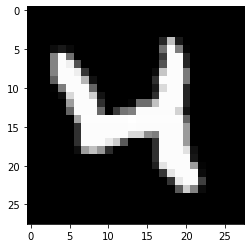

In [ ]:
img, label = trainset[20]
print('Label: ', label)
print('Image shape: ', img.shape)
plt.imshow(img[0], cmap='gray')

In [ ]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
a_layer = nn.Linear(2, 4)           # we create a layer
print("transposed weight: ", a_layer.weight.T)   # print the weight of the layer
print("bias: ", a_layer.bias)       # print the bias of the layer
input = torch.rand((3, 2))          # we create a dummy input
print('input: ', input)
# your code here      
output = torch.matmul(input,a_layer.weight.T) + a_layer.bias
print('output: ', output)

transposed weight:  tensor([[-0.2118,  0.3121,  0.0043, -0.4079],
        [ 0.2764,  0.7036, -0.5212,  0.4714]], grad_fn=<PermuteBackward0>)
bias:  Parameter containing:
tensor([ 0.6572, -0.5016, -0.3221,  0.6282], requires_grad=True)
input:  tensor([[0.1805, 0.6322],
        [0.1842, 0.3947],
        [0.2307, 0.8958]])
output:  tensor([[ 7.9374e-01, -4.1825e-04, -6.5082e-01,  8.5257e-01],
        [ 7.2730e-01, -1.6636e-01, -5.2701e-01,  7.3907e-01],
        [ 8.5595e-01,  2.0070e-01, -7.8799e-01,  9.5635e-01]],
       grad_fn=<AddBackward0>)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 120)  # first hidden layer
        self.fc2 = nn.Linear(120, 84)     # second hidden layer
        # your code here
        self.additional_layer = nn.Linear(84,84)
        self.fc3 = nn.Linear(84, 10)      # output layer

    def forward(self, x):
        x = torch.flatten(x, 1)   # flatten all dimensions except batch
        x = F.relu(self.fc1(x))   # compute output of first hidden layer + activation function
        x = F.relu(self.fc2(x))   # compute output of second hiddlen layer + activation function
        # your code here
        x = F.relu(self.additional_layer(x))
        x = self.fc3(x)           # compute output
        return x                  # return output

model = Net()

In [ ]:
def softmax(z):
  # your code here
  denominator = torch.sum(torch.exp(z),axis=1)
  output_list = []
  for i in range(z.size()[0]):
    output_list.append(torch.exp(z[i])/denominator[i])
  output = torch.stack(output_list)
  return output

In [ ]:
def log_softmax(z):
  return softmax(z).log()

In [ ]:
def nll(preds, target):
  # your code here
  #print(target.size()[0])
  #print(target)
  target_one_hot = torch.zeros(preds.shape)
  for i in range(target.size()[0]):
    target_one_hot[i][target[i]] = 1
  #print(target_one_hot)
  l = -preds * target_one_hot
  return l

In [ ]:
def cross_entropy_loss(z, target):
  #print(nll(log_softmax(z),target))
  return torch.sum(nll(log_softmax(z), target),axis=1).mean()

loss_function = nn.CrossEntropyLoss()
z = torch.rand((3, 10))
#print(z)
target = torch.tensor([0, 5, 9], dtype=torch.long)
print("cross_entropy_loss",cross_entropy_loss(z, target))
print("loss ",loss_function(z, target))

assert cross_entropy_loss(z, target) == loss_function(z, target), 'The two above task are not correct!'

cross_entropy_loss tensor(2.3909)
loss  tensor(2.3909)


In [ ]:
def CEloss_with_l2(z, target, model, alpha):
  CE_loss = cross_entropy_loss(z, target)
  # Your code here
  L2_loss = 0
  for param in model.parameters():
    L2_loss +=  torch.sum(param ** 2)
  loss = CE_loss + alpha * L2_loss
  return loss

CEloss_with_l2(torch.rand(2, 10), torch.tensor([2, 3], dtype=torch.long), model, 0.001)

tensor(2.2331, grad_fn=<AddBackward0>)

In [ ]:
def CEloss_with_l1(z, target, model, alpha):
  # Your code here
  CE_loss = cross_entropy_loss(z,target)
  L1_loss = 0
  for param in model.parameters():
    L1_loss += torch.sum(torch.abs(param))
  loss = CE_loss + alpha * L1_loss
  return loss

CEloss_with_l1(torch.rand(2, 10), torch.tensor([2, 3], dtype=torch.long), model, 0.001)

tensor(4.9981, grad_fn=<AddBackward0>)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
model.cuda()    # move model to GPU for faster computation in parallel
n_epochs = 7    # you should change to larger value
for epoch in range(n_epochs):
  print(f'Epoch {epoch}- Training... ')
  for batch_idx, (imgs, labels) in enumerate(tqdm(train_dataloader)):
    imgs = imgs.cuda()      # move images to GPU
    labels = labels.cuda()  # move labels to GPU
    optimizer.zero_grad()   # by default, Pytorch's optimizer retains gradient after apply Gradient Descent. We need to call this function to clear gradients explicitly.
    preds = model(imgs)     # pass batch of data through the model. 
    loss = loss_function(preds, labels)   # compute loss 
    loss.backward()         # compute gradient by running backpropgation algorithm
    optimizer.step()        # apply Gradient Descent
  
  # evaluate 
  print(f'Epoch {epoch}- Evaluating... ')
  total_correct = 0
  total = len(testset)
  for batch_indx, (imgs, labels) in enumerate(tqdm(test_dataloader)):
    imgs = imgs.cuda()
    labels = labels.cuda()
    preds = model(imgs).argmax(axis=-1)
    #loss = loss_function(preds, labels)
    #loss.backward()
    n_correct = torch.sum(preds == labels)
    total_correct += n_correct.item()
  
  print("Accuracy: ", total_correct/total)


Epoch 0- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 245.36it/s]


Epoch 0- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 215.91it/s]


Accuracy:  0.9461
Epoch 1- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 241.58it/s]


Epoch 1- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 211.08it/s]


Accuracy:  0.9529
Epoch 2- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 246.32it/s]


Epoch 2- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 212.55it/s]


Accuracy:  0.9591
Epoch 3- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 246.84it/s]


Epoch 3- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 211.69it/s]


Accuracy:  0.9648
Epoch 4- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 245.27it/s]


Epoch 4- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 208.66it/s]


Accuracy:  0.9667
Epoch 5- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 236.76it/s]


Epoch 5- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 210.01it/s]


Accuracy:  0.9702
Epoch 6- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 244.24it/s]


Epoch 6- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 207.29it/s]

Accuracy:  0.9674


Prediction: 7 - confident score: 99.92633819580078


<ipython-input-30-2c74712a8e11>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(img).cuda()   # convert image to tensor to be able to pass through model, and model the image to GPU


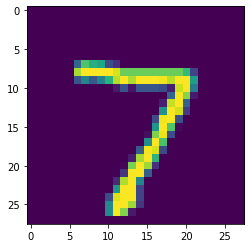

In [ ]:
img, label = testset[0]   # you can change the index
input_tensor = torch.tensor(img).cuda()   # convert image to tensor to be able to pass through model, and model the image to GPU
output = model(input_tensor)
# your code here
value = model(input_tensor).argmax(axis=-1)[0]
confident_score = softmax(model(input_tensor))[0].max() * 100
print(f"Prediction: {value} - confident score: {confident_score}")
plt.imshow(img[0])